In [73]:
import numpy as np
import kagglehub

In [74]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/timakaaliebe/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [75]:
import matplotlib.pyplot as plt
import struct
import os


def load_mnist_images(filename):
    """Load MNIST images from IDX file format"""
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images


def load_mnist_labels(filename):
    """Load MNIST labels from IDX file format"""
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# Load training data
train_images = load_mnist_images(os.path.join(path, "train-images.idx3-ubyte"))
train_labels = load_mnist_labels(os.path.join(path, "train-labels.idx1-ubyte"))

# Load test data
test_images = load_mnist_images(os.path.join(path, "t10k-images.idx3-ubyte"))
test_labels = load_mnist_labels(os.path.join(path, "t10k-labels.idx1-ubyte"))

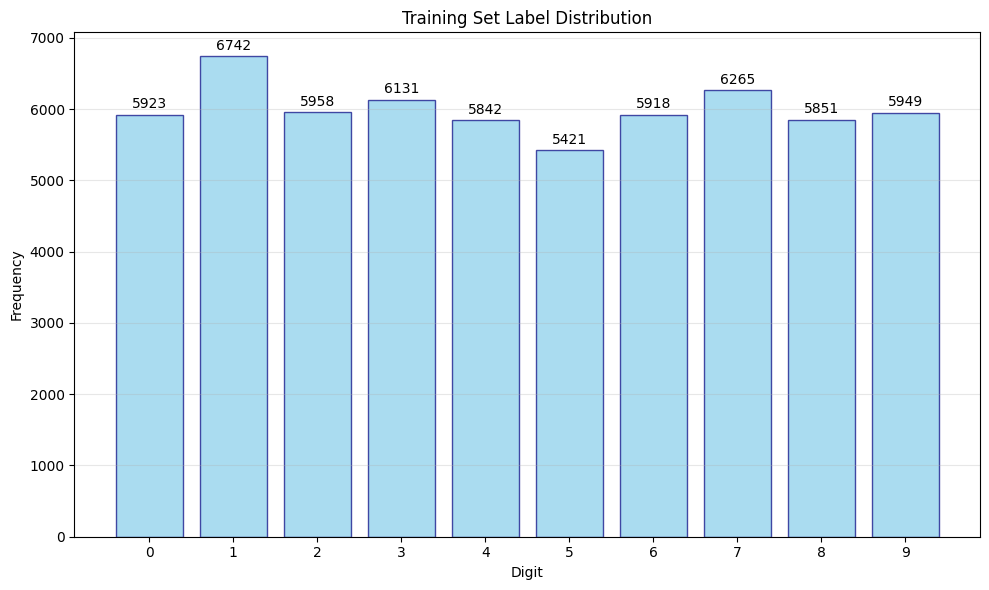

In [76]:
# Display distribution of labels
def plot_label_distribution(labels, title="Label Distribution"):
    """Plot the distribution of labels in the dataset"""
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique, counts, color="skyblue", edgecolor="navy", alpha=0.7)
    plt.xlabel("Digit")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique)

    # Add count labels on top of bars
    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 50,
            str(count),
            ha="center",
            va="bottom",
        )

    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot training set label distribution
plot_label_distribution(train_labels, "Training Set Label Distribution")

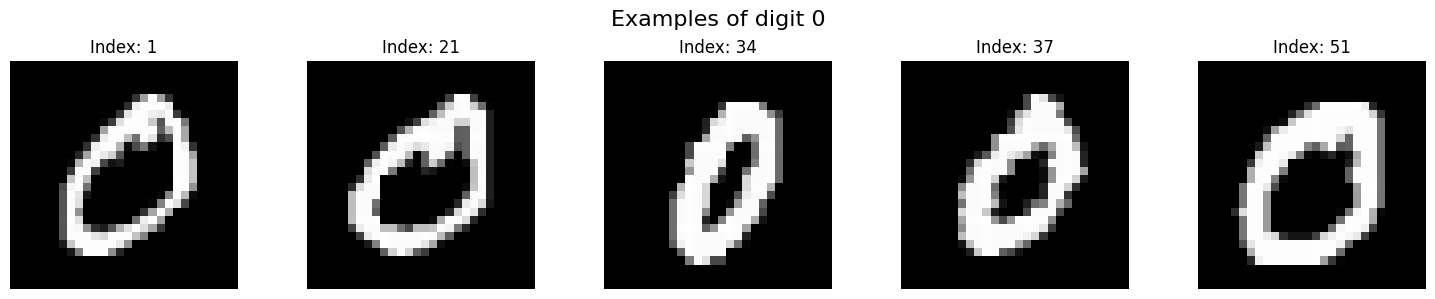

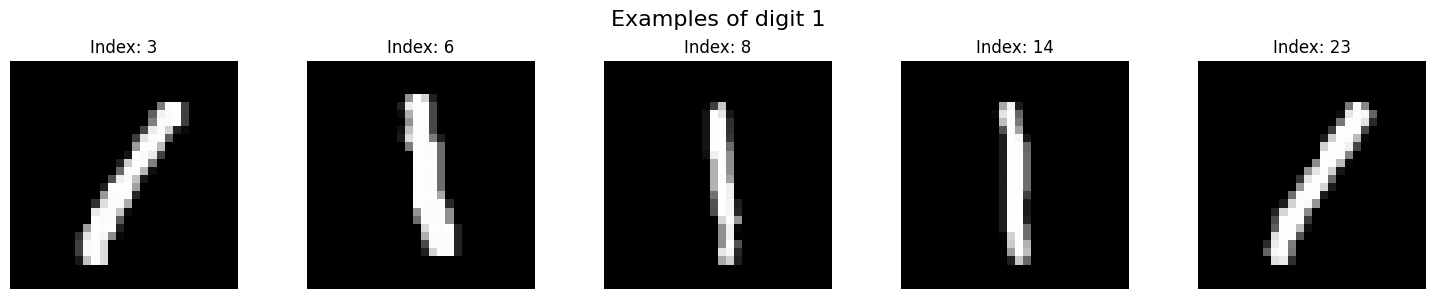

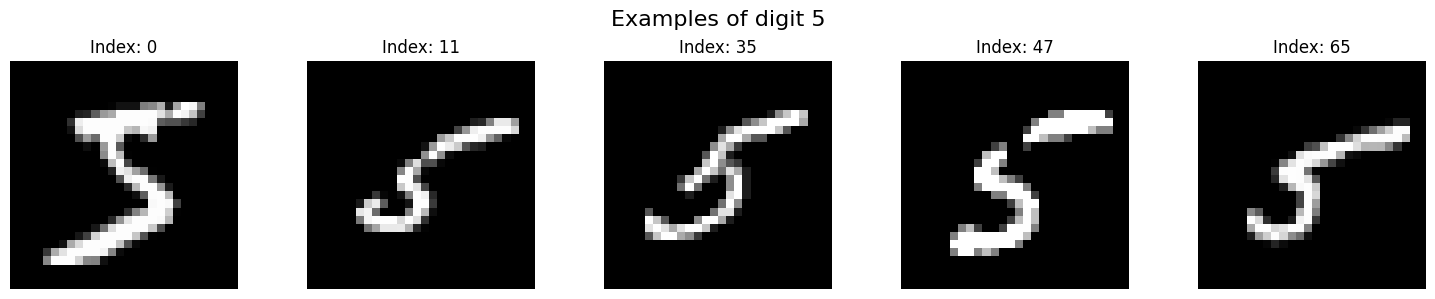

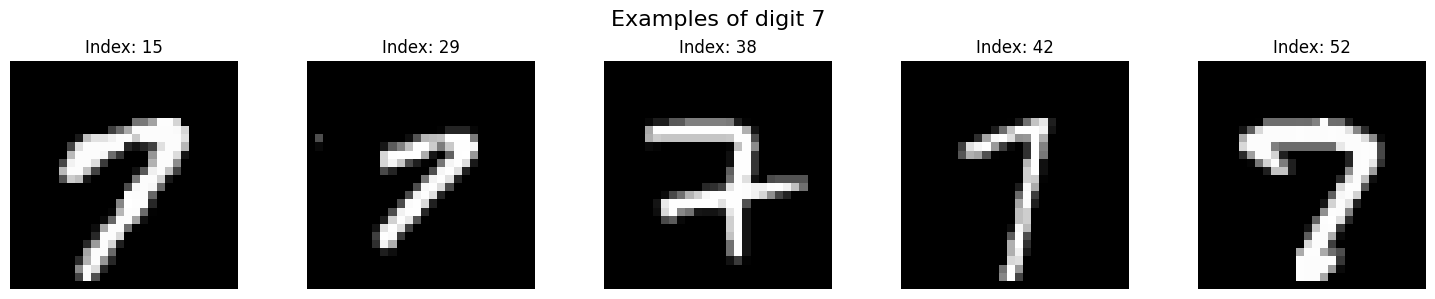

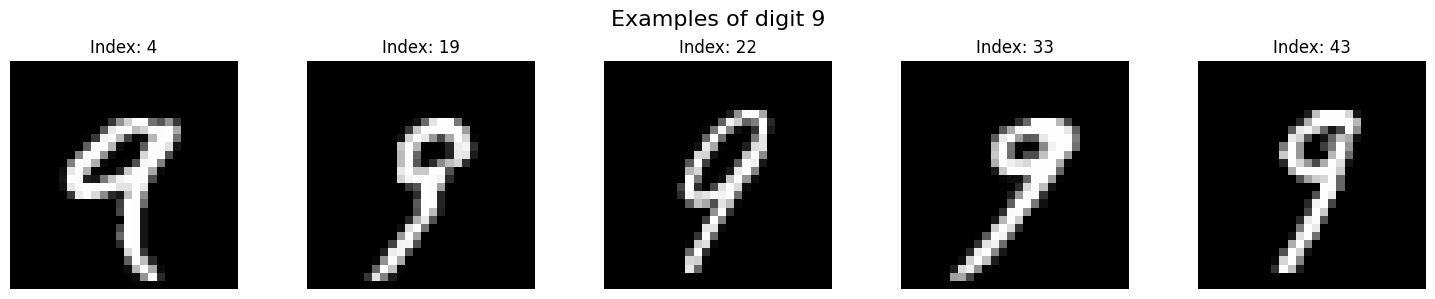

In [77]:
# Display specific digit examples
def show_digit_examples(images, labels, digit, num_examples=5):
    """Show examples of a specific digit"""
    digit_indices = np.where(labels == digit)[0][:num_examples]

    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    fig.suptitle(f"Examples of digit {digit}", fontsize=16)

    for i, idx in enumerate(digit_indices):
        axes[i].imshow(images[idx], cmap="gray")
        axes[i].set_title(f"Index: {idx}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Show examples of different digits
for digit in [0, 1, 5, 7, 9]:
    show_digit_examples(train_images, train_labels, digit)

In [78]:
# Step 1a: Examine the raw data structure
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Look at pixel value ranges
print(f"\nPixel value range: {train_images.min()} to {train_images.max()}")
print(f"Data type: {train_images.dtype}")

# Look at a single image
print(f"\nSingle image shape: {train_images[0].shape}")
print("First few pixel values of first image:")
print(train_images[0][:5, :5])  # Show 5x5 corner

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)

Pixel value range: 0 to 255
Data type: uint8

Single image shape: (28, 28)
First few pixel values of first image:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [79]:
# Step 1b: Data Preprocessing

# 1. NORMALIZATION: Scale pixel values from [0, 255] to [0, 1]
# Why? Large input values can cause exploding gradients during training
print("=== NORMALIZATION ===")
print("Before normalization:")
print(f"Min: {train_images.min()}, Max: {train_images.max()}")

# Normalize by dividing by 255 (the maximum pixel value)
X_train = train_images.astype(np.float32) / 255.0
X_test = test_images.astype(np.float32) / 255.0

print("After normalization:")
print(f"Min: {X_train.min()}, Max: {X_train.max()}")

# 2. FLATTENING: Convert 28x28 images to 784-length vectors
# Why? Neural networks expect 1D input vectors, not 2D matrices
print(f"\n=== FLATTENING ===")
print(f"Before flattening: {X_train.shape}")

X_train_flat = X_train.reshape(
    X_train.shape[0], -1
)  # -1 means "calculate this dimension"
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"After flattening: {X_train_flat.shape}")
print(f"Each image is now a vector of length: {X_train_flat.shape[1]}")
print(f"This equals 28 × 28 = {28*28}")

=== NORMALIZATION ===
Before normalization:
Min: 0, Max: 255
After normalization:
Min: 0.0, Max: 1.0

=== FLATTENING ===
Before flattening: (60000, 28, 28)
After flattening: (60000, 784)
Each image is now a vector of length: 784
This equals 28 × 28 = 784


In [80]:
# Step 1c: One-Hot Encoding for Labels

# 3. ONE-HOT ENCODING: Convert labels from integers to probability vectors
# Why? For classification, we need outputs that represent probabilities for each class
print("=== ONE-HOT ENCODING ===")
print("Original labels (first 10):", train_labels[:10])
print("Label for first image:", train_labels[0])


# Create one-hot encoding manually (understanding the concept)
def to_one_hot(labels, num_classes=10):
    """
    Convert integer labels to one-hot encoded vectors
    Example: label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    """
    one_hot = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1
    return one_hot


# Apply one-hot encoding
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

print(f"\nAfter one-hot encoding:")
print(f"y_train shape: {y_train.shape}")
print(f"Original label: {train_labels[0]}")
print(f"One-hot encoded: {y_train[0]}")
print(f"Sum of one-hot vector: {y_train[0].sum()} (should be 1.0)")

=== ONE-HOT ENCODING ===
Original labels (first 10): [5 0 4 1 9 2 1 3 1 4]
Label for first image: 5

After one-hot encoding:
y_train shape: (60000, 10)
Original label: 5
One-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Sum of one-hot vector: 1.0 (should be 1.0)


In [81]:
# Step 2a: Implement Activation Functions

# Let's implement the mathematical functions our neurons will use


def sigmoid(z):
    """
    Sigmoid activation function: σ(z) = 1 / (1 + e^(-z))

    Properties:
    - Outputs values between 0 and 1
    - Good for binary classification
    - Can cause vanishing gradient problem
    """
    # Clip z to prevent overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))


def relu(z):
    """
    ReLU (Rectified Linear Unit): σ(z) = max(0, z)

    Properties:
    - Outputs 0 for negative inputs, z for positive inputs
    - Computationally efficient
    - Helps with vanishing gradient problem
    - Most popular activation for hidden layers
    """
    return np.maximum(0, z)


def softmax(z):
    """
    Softmax activation: σ(z_i) = e^(z_i) / Σ(e^(z_j))

    Properties:
    - Converts logits to probability distribution
    - All outputs sum to 1
    - Perfect for multi-class classification
    """
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


# Test our activation functions
print("=== TESTING ACTIVATION FUNCTIONS ===")
test_input = np.array([[-2, -1, 0, 1, 2]])

print("Input:", test_input[0])
print("Sigmoid:", sigmoid(test_input)[0])
print("ReLU:", relu(test_input)[0])
print("Softmax:", softmax(test_input)[0])
print("Softmax sum:", np.sum(softmax(test_input)[0]))

=== TESTING ACTIVATION FUNCTIONS ===
Input: [-2 -1  0  1  2]
Sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
ReLU: [0 0 0 1 2]
Softmax: [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
Softmax sum: 1.0


In [82]:
# Step 2b: Initialize Network Parameters (Weights and Biases)


def initialize_parameters(input_size, hidden_size, output_size):
    """
    Initialize weights and biases for our neural network

    Why random initialization?
    - If all weights are the same, all neurons learn the same thing
    - Random initialization breaks symmetry
    - We use small random values to prevent saturation
    """
    np.random.seed(42)  # For reproducible results

    # Xavier/Glorot initialization - helps with gradient flow
    # Scale weights by sqrt(1/fan_in) where fan_in is number of input connections

    # Weights from input layer to hidden layer
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    b1 = np.zeros((1, hidden_size))  # Biases start at zero

    # Weights from hidden layer to output layer
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    b2 = np.zeros((1, output_size))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return parameters


# Initialize our network
input_size = 784  # 28x28 pixels
hidden_size = 128  # Hidden layer neurons
output_size = 10  # 10 digit classes

params = initialize_parameters(input_size, hidden_size, output_size)

print("=== NETWORK PARAMETER SHAPES ===")
print(f"W1 (input→hidden): {params['W1'].shape}")
print(f"b1 (hidden bias): {params['b1'].shape}")
print(f"W2 (hidden→output): {params['W2'].shape}")
print(f"b2 (output bias): {params['b2'].shape}")

print(f"\n=== SAMPLE WEIGHT VALUES ===")
print(f"W1 first 3x3 corner:\n{params['W1'][:3, :3]}")
print(f"W1 statistics: mean={params['W1'].mean():.4f}, std={params['W1'].std():.4f}")

=== NETWORK PARAMETER SHAPES ===
W1 (input→hidden): (784, 128)
b1 (hidden bias): (1, 128)
W2 (hidden→output): (128, 10)
b2 (output bias): (1, 10)

=== SAMPLE WEIGHT VALUES ===
W1 first 3x3 corner:
[[ 0.01773979 -0.00493801  0.02313173]
 [ 0.00355898 -0.01798127 -0.05538084]
 [ 0.04524683 -0.02527391  0.01585069]]
W1 statistics: mean=0.0000, std=0.0357


In [83]:
# Step 2c: Forward Propagation - Making Predictions


def forward_propagation(X, parameters):
    """
    Perform forward propagation through the network

    This is how we make predictions:
    1. Take input X (images)
    2. Multiply by weights, add biases (linear transformation)
    3. Apply activation function (non-linear transformation)
    4. Repeat for each layer
    """
    # Extract parameters
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]

    # Layer 1: Input → Hidden
    # Z1 = X·W1 + b1 (linear transformation)
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)  # Apply ReLU activation

    # Layer 2: Hidden → Output
    # Z2 = A1·W2 + b2 (linear transformation)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)  # Apply softmax for probabilities

    # Store intermediate values for later use (backpropagation)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

    return A2, cache


# Test forward propagation with a few images
print("=== TESTING FORWARD PROPAGATION ===")

# Take first 5 images
sample_X = X_train_flat[:5]
sample_y = y_train[:5]

print(f"Input shape: {sample_X.shape}")
print(f"Expected output shape: (5, 10)")

# Make predictions
predictions, cache = forward_propagation(sample_X, params)

print(f"Actual output shape: {predictions.shape}")
print(f"\nFirst prediction probabilities:")
print(predictions[0])
print(f"Sum of probabilities: {predictions[0].sum():.6f} (should be 1.0)")

# Convert predictions to class predictions
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(sample_y, axis=1)

print(f"\nPredicted classes: {predicted_classes}")
print(f"Actual classes:    {actual_classes}")
print("(These will be random since we haven't trained yet!)")

=== TESTING FORWARD PROPAGATION ===
Input shape: (5, 784)
Expected output shape: (5, 10)
Actual output shape: (5, 10)

First prediction probabilities:
[0.12251202 0.09791901 0.10040491 0.06817335 0.08501201 0.11701899
 0.07597875 0.1240025  0.08994654 0.11903191]
Sum of probabilities: 1.000000 (should be 1.0)

Predicted classes: [7 5 7 9 7]
Actual classes:    [5 0 4 1 9]
(These will be random since we haven't trained yet!)


=== VISUALIZING UNTRAINED NETWORK PREDICTIONS ===


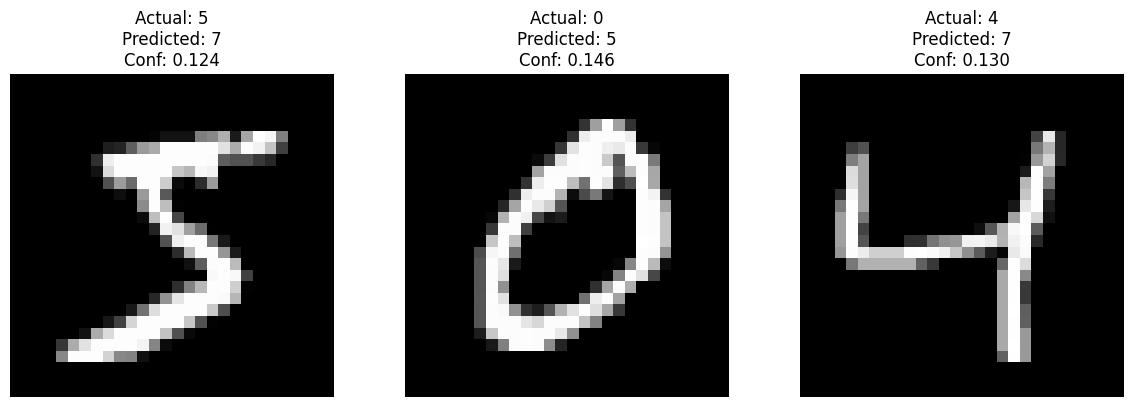


=== PREDICTION CONFIDENCE ANALYSIS ===
Confidence scores: [0.1240025  0.14560904 0.13026521 0.11671229 0.1274292 ]
Average confidence: 0.129
With random guessing, we'd expect ~0.100 confidence


In [84]:
# Step 2d: Visualizing Network Predictions (Before Training)


# Let's visualize what our untrained network predicts
def visualize_predictions(X, y, predictions, num_samples=3):
    """Visualize images with their actual and predicted labels"""
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        # Reshape flattened image back to 28x28
        image = X[i].reshape(28, 28)

        # Get actual and predicted labels
        actual_label = np.argmax(y[i])
        predicted_label = np.argmax(predictions[i])
        predicted_prob = np.max(predictions[i])

        # Display image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(
            f"Actual: {actual_label}\nPredicted: {predicted_label}\nConf: {predicted_prob:.3f}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


print("=== VISUALIZING UNTRAINED NETWORK PREDICTIONS ===")
visualize_predictions(sample_X, sample_y, predictions)

# Show prediction confidence distribution
print(f"\n=== PREDICTION CONFIDENCE ANALYSIS ===")
max_probs = np.max(predictions, axis=1)
print(f"Confidence scores: {max_probs}")
print(f"Average confidence: {max_probs.mean():.3f}")
print(f"With random guessing, we'd expect ~{1/10:.3f} confidence")

In [85]:
# Step 3a: Loss Function - Measuring How Wrong We Are


def compute_loss(y_true, y_pred):
    """
    Cross-entropy loss for multi-class classification

    Mathematical formula: L = -Σ(y_true * log(y_pred))

    Why cross-entropy?
    - Penalizes confident wrong predictions heavily
    - Gradient becomes larger when prediction is more wrong
    - Perfect for probability distributions (softmax output)
    """
    m = y_true.shape[0]  # Number of examples

    # Add small epsilon to prevent log(0)
    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / m

    return loss


def compute_accuracy(y_true, y_pred):
    """Calculate prediction accuracy"""
    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy


# Test loss function with our untrained network
print("=== TESTING LOSS FUNCTION ===")

sample_loss = compute_loss(sample_y, predictions)
sample_accuracy = compute_accuracy(sample_y, predictions)

print(f"Current loss: {sample_loss:.4f}")
print(f"Current accuracy: {sample_accuracy:.4f} ({sample_accuracy*100:.1f}%)")

# What should we expect?
print(f"\nRandom guessing would give:")
print(f"- Accuracy ≈ {1/10:.3f} ({100/10:.1f}%)")
print(f"- Loss ≈ {-np.log(1/10):.3f}")

# Show how loss changes with different predictions
print(f"\n=== UNDERSTANDING LOSS VALUES ===")
perfect_pred = np.copy(sample_y)  # Perfect predictions
random_pred = np.ones_like(sample_y) / 10  # Random predictions

print(f"Perfect predictions loss: {compute_loss(sample_y, perfect_pred):.6f}")
print(f"Random predictions loss: {compute_loss(sample_y, random_pred):.4f}")
print(f"Our current loss: {sample_loss:.4f}")

=== TESTING LOSS FUNCTION ===
Current loss: 2.3014
Current accuracy: 0.0000 (0.0%)

Random guessing would give:
- Accuracy ≈ 0.100 (10.0%)
- Loss ≈ 2.303

=== UNDERSTANDING LOSS VALUES ===
Perfect predictions loss: 0.000000
Random predictions loss: 2.3026
Our current loss: 2.3014


In [86]:
# Step 3b: Understanding Gradients - The Direction of Improvement


def relu_derivative(z):
    """
    Derivative of ReLU: 1 if z > 0, else 0
    This tells us how much the output changes when input changes
    """
    return (z > 0).astype(float)


# Let's understand gradients conceptually first
print("=== UNDERSTANDING GRADIENTS ===")

# Simple example: How does loss change when we change a weight?
print("Gradient = How much loss changes when we change a parameter")
print("\nExample with a simple function: f(x) = x²")
print("Derivative: f'(x) = 2x")

x_values = np.array([-2, -1, 0, 1, 2])
gradients = 2 * x_values

print(f"x values: {x_values}")
print(f"Gradients: {gradients}")
print(f"Interpretation:")
for i, (x, grad) in enumerate(zip(x_values, gradients)):
    direction = "decrease" if grad < 0 else "increase" if grad > 0 else "stay same"
    print(
        f"  At x={x}: gradient={grad}, move x in negative direction to {direction} f(x)"
    )

print(f"\n=== CHAIN RULE CONCEPT ===")
print(
    "For neural networks: ∂Loss/∂Weight = ∂Loss/∂Output × ∂Output/∂Input × ∂Input/∂Weight"
)
print("We'll trace this backwards through each layer (hence 'backpropagation')")

# Test derivative functions
print(f"\n=== TESTING ACTIVATION DERIVATIVES ===")
test_z = np.array([-2, -1, 0, 1, 2])
print(f"z values: {test_z}")
print(f"ReLU(z): {relu(test_z)}")
print(f"ReLU'(z): {relu_derivative(test_z)}")
print("Notice: ReLU derivative is 0 for negative inputs, 1 for positive")

=== UNDERSTANDING GRADIENTS ===
Gradient = How much loss changes when we change a parameter

Example with a simple function: f(x) = x²
Derivative: f'(x) = 2x
x values: [-2 -1  0  1  2]
Gradients: [-4 -2  0  2  4]
Interpretation:
  At x=-2: gradient=-4, move x in negative direction to decrease f(x)
  At x=-1: gradient=-2, move x in negative direction to decrease f(x)
  At x=0: gradient=0, move x in negative direction to stay same f(x)
  At x=1: gradient=2, move x in negative direction to increase f(x)
  At x=2: gradient=4, move x in negative direction to increase f(x)

=== CHAIN RULE CONCEPT ===
For neural networks: ∂Loss/∂Weight = ∂Loss/∂Output × ∂Output/∂Input × ∂Input/∂Weight
We'll trace this backwards through each layer (hence 'backpropagation')

=== TESTING ACTIVATION DERIVATIVES ===
z values: [-2 -1  0  1  2]
ReLU(z): [0 0 0 1 2]
ReLU'(z): [0. 0. 0. 1. 1.]
Notice: ReLU derivative is 0 for negative inputs, 1 for positive


In [87]:
# Step 3c: Backpropagation - Computing Gradients Layer by Layer


def backward_propagation(X, y, cache, parameters):
    """
    Implement backpropagation to compute gradients

    This is the mathematical heart of neural network learning!
    We use the chain rule to compute how much each weight contributes to the loss.
    """
    m = X.shape[0]  # Number of examples

    # Extract forward propagation results
    A1, A2 = cache["A1"], cache["A2"]
    Z1 = cache["Z1"]

    # Extract parameters
    W2 = parameters["W2"]

    # === LAYER 2 GRADIENTS (Output layer) ===

    # For softmax + cross-entropy, the gradient simplifies to:
    # dZ2 = A2 - y (predicted probabilities - true labels)
    dZ2 = A2 - y

    # Gradients for W2 and b2
    # ∂L/∂W2 = (1/m) × A1ᵀ × dZ2
    dW2 = (1 / m) * np.dot(A1.T, dZ2)

    # ∂L/∂b2 = (1/m) × sum(dZ2) along examples axis
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)

    # === LAYER 1 GRADIENTS (Hidden layer) ===

    # Gradient flowing back from layer 2
    # ∂L/∂A1 = dZ2 × W2ᵀ
    dA1 = np.dot(dZ2, W2.T)

    # Apply ReLU derivative: ∂A1/∂Z1 = ReLU'(Z1)
    dZ1 = dA1 * relu_derivative(Z1)

    # Gradients for W1 and b1
    # ∂L/∂W1 = (1/m) × Xᵀ × dZ1
    dW1 = (1 / m) * np.dot(X.T, dZ1)

    # ∂L/∂b1 = (1/m) × sum(dZ1) along examples axis
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return gradients


# Test backpropagation
print("=== TESTING BACKPROPAGATION ===")

gradients = backward_propagation(sample_X, sample_y, cache, params)

print("Gradient shapes:")
for key, grad in gradients.items():
    print(f"{key}: {grad.shape}")

print(f"\nSample gradient values:")
print(f"dW1 first 3x3 corner:\n{gradients['dW1'][:3, :3]}")
print(
    f"dW1 statistics: mean={gradients['dW1'].mean():.6f}, std={gradients['dW1'].std():.6f}"
)

print(f"\ndW2 first 3x3 corner:\n{gradients['dW2'][:3, :3]}")
print(
    f"dW2 statistics: mean={gradients['dW2'].mean():.6f}, std={gradients['dW2'].std():.6f}"
)

print(f"\nGradient interpretation:")
print("- Positive gradient: increasing weight increases loss → decrease weight")
print("- Negative gradient: increasing weight decreases loss → increase weight")
print("- Large gradient magnitude: weight has strong effect on loss")

=== TESTING BACKPROPAGATION ===
Gradient shapes:
dW1: (784, 128)
db1: (1, 128)
dW2: (128, 10)
db2: (1, 10)

Sample gradient values:
dW1 first 3x3 corner:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
dW1 statistics: mean=-0.000037, std=0.007509

dW2 first 3x3 corner:
[[ 0.00322899 -0.00102723  0.00742353]
 [-0.09513715  0.02419519  0.02292817]
 [-0.00075111  0.00382085  0.00343129]]
dW2 statistics: mean=0.000000, std=0.025333

Gradient interpretation:
- Positive gradient: increasing weight increases loss → decrease weight
- Negative gradient: increasing weight decreases loss → increase weight
- Large gradient magnitude: weight has strong effect on loss


In [88]:
# Step 3d: Gradient Descent - Updating Weights to Learn


def update_parameters(parameters, gradients, learning_rate):
    """
    Update network parameters using gradient descent

    Formula: W_new = W_old - learning_rate × gradient

    Learning rate controls step size:
    - Too large: might overshoot minimum
    - Too small: very slow learning
    """
    # Update weights and biases
    parameters["W1"] = parameters["W1"] - learning_rate * gradients["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * gradients["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * gradients["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * gradients["db2"]

    return parameters


# Test one training step
print("=== TESTING GRADIENT DESCENT UPDATE ===")

# Store original parameters for comparison
original_W1 = params["W1"].copy()
learning_rate = 0.1

print(f"Learning rate: {learning_rate}")
print(f"W1 before update (first 3x3):\n{params['W1'][:3, :3]}")

# Update parameters
params = update_parameters(params, gradients, learning_rate)

print(f"W1 after update (first 3x3):\n{params['W1'][:3, :3]}")

# Calculate the change
weight_change = params["W1"][:3, :3] - original_W1[:3, :3]
print(f"Change in W1 (first 3x3):\n{weight_change}")

print(f"\nWeight update formula verification:")
expected_change = -learning_rate * gradients["dW1"][:3, :3]
print(f"Expected change: -lr × gradient:\n{expected_change}")
print(f"Actual change matches expected: {np.allclose(weight_change, expected_change)}")

# Show how loss should change after update
print(f"\n=== CHECKING IF LOSS IMPROVED ===")
new_predictions, new_cache = forward_propagation(sample_X, params)
new_loss = compute_loss(sample_y, new_predictions)
new_accuracy = compute_accuracy(sample_y, new_predictions)

print(f"Old loss: {sample_loss:.6f}")
print(f"New loss: {new_loss:.6f}")
print(f"Loss change: {new_loss - sample_loss:.6f}")
print(
    f"Loss {'decreased' if new_loss < sample_loss else 'increased'} (good if decreased)"
)

print(f"\nOld accuracy: {sample_accuracy:.4f}")
print(f"New accuracy: {new_accuracy:.4f}")
print("Note: One step might not improve accuracy, but loss should generally decrease")

=== TESTING GRADIENT DESCENT UPDATE ===
Learning rate: 0.1
W1 before update (first 3x3):
[[ 0.01773979 -0.00493801  0.02313173]
 [ 0.00355898 -0.01798127 -0.05538084]
 [ 0.04524683 -0.02527391  0.01585069]]
W1 after update (first 3x3):
[[ 0.01773979 -0.00493801  0.02313173]
 [ 0.00355898 -0.01798127 -0.05538084]
 [ 0.04524683 -0.02527391  0.01585069]]
Change in W1 (first 3x3):
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Weight update formula verification:
Expected change: -lr × gradient:
[[-0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0. -0.]]
Actual change matches expected: True

=== CHECKING IF LOSS IMPROVED ===
Old loss: 2.301400
New loss: 1.759373
Loss change: -0.542027
Loss decreased (good if decreased)

Old accuracy: 0.0000
New accuracy: 1.0000
Note: One step might not improve accuracy, but loss should generally decrease


In [89]:
# Step 3e: Complete Training Loop - Putting It All Together


def train_neural_network(X, y, parameters, epochs=10, learning_rate=0.1, print_every=2):
    """
    Complete training loop combining all components:
    1. Forward propagation (predictions)
    2. Compute loss
    3. Backward propagation (gradients)
    4. Update parameters (learning)
    """

    costs = []
    accuracies = []

    for epoch in range(epochs):
        # Forward propagation
        predictions, cache = forward_propagation(X, parameters)

        # Compute cost and accuracy
        cost = compute_loss(y, predictions)
        accuracy = compute_accuracy(y, predictions)

        # Backward propagation
        gradients = backward_propagation(X, y, cache, parameters)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Store metrics
        costs.append(cost)
        accuracies.append(accuracy)

        # Print progress
        if epoch % print_every == 0:
            print(
                f"Epoch {epoch:2d}: Loss = {cost:.4f}, Accuracy = {accuracy:.4f} ({accuracy*100:.1f}%)"
            )

    return parameters, costs, accuracies


# Reset parameters for clean training
print("=== TRAINING NEURAL NETWORK ===")
print("Let's train on a small subset first to see learning in action\n")

# Reinitialize parameters
params = initialize_parameters(input_size, hidden_size, output_size)

# Train on first 100 examples for 20 epochs
small_X = X_train_flat[:100]
small_y = y_train[:100]

# Start training!
trained_params, training_costs, training_accuracies = train_neural_network(
    small_X, small_y, params, epochs=20, learning_rate=0.1, print_every=2
)

print(f"\n=== TRAINING RESULTS ===")
print(
    f"Initial accuracy: {training_accuracies[0]:.4f} ({training_accuracies[0]*100:.1f}%)"
)
print(
    f"Final accuracy: {training_accuracies[-1]:.4f} ({training_accuracies[-1]*100:.1f}%)"
)
print(
    f"Improvement: {(training_accuracies[-1] - training_accuracies[0])*100:.1f} percentage points"
)

print(f"\nInitial loss: {training_costs[0]:.4f}")
print(f"Final loss: {training_costs[-1]:.4f}")
print(f"Loss reduction: {training_costs[0] - training_costs[-1]:.4f}")

=== TRAINING NEURAL NETWORK ===
Let's train on a small subset first to see learning in action

Epoch  0: Loss = 2.3525, Accuracy = 0.0800 (8.0%)
Epoch  2: Loss = 2.1569, Accuracy = 0.3500 (35.0%)
Epoch  4: Loss = 1.9905, Accuracy = 0.5500 (55.0%)
Epoch  6: Loss = 1.8357, Accuracy = 0.6200 (62.0%)
Epoch  8: Loss = 1.6910, Accuracy = 0.6900 (69.0%)
Epoch 10: Loss = 1.5551, Accuracy = 0.7400 (74.0%)
Epoch 12: Loss = 1.4261, Accuracy = 0.7700 (77.0%)
Epoch 14: Loss = 1.3046, Accuracy = 0.8000 (80.0%)
Epoch 16: Loss = 1.1920, Accuracy = 0.8400 (84.0%)
Epoch 18: Loss = 1.0881, Accuracy = 0.8700 (87.0%)

=== TRAINING RESULTS ===
Initial accuracy: 0.0800 (8.0%)
Final accuracy: 0.8900 (89.0%)
Improvement: 81.0 percentage points

Initial loss: 2.3525
Final loss: 1.0394
Loss reduction: 1.3132


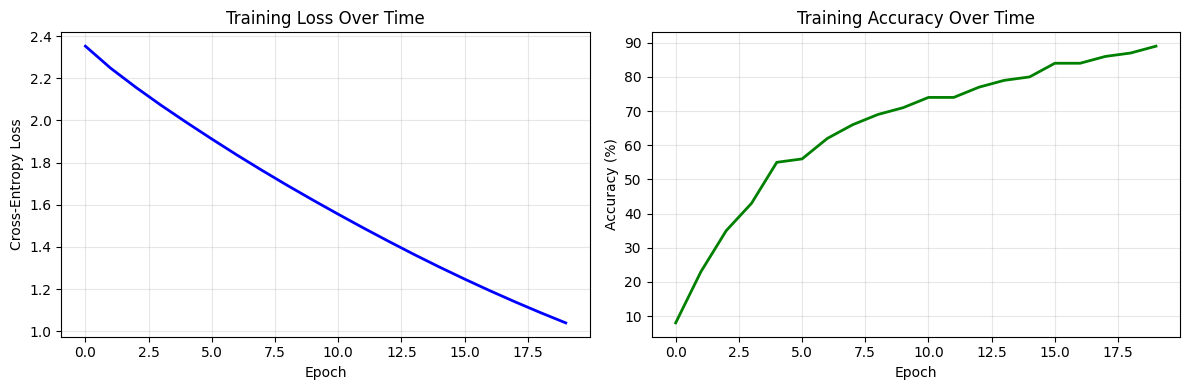

=== TESTING TRAINED NETWORK ===
Comparing predictions before and after training:
Image | Actual | Before Training | After Training | Improved?
-----------------------------------------------------------------
  0   |   5    |        7        |       3       | ✗
  1   |   0    |        5        |       0       | ✓
  2   |   4    |        7        |       4       | ✓
  3   |   1    |        9        |       1       | ✓
  4   |   9    |        7        |       9       | ✓

Confidence improvement:
Average confidence before: 0.129
Average confidence after:  0.439
Confidence increase: 0.310

=== VISUALIZING TRAINED PREDICTIONS ===


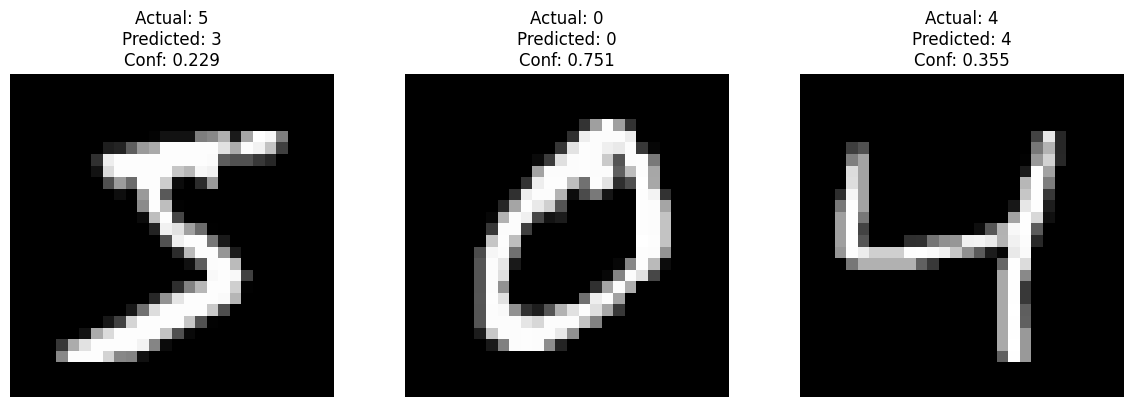

In [90]:
# Step 3f: Visualizing the Learning Process

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(training_costs, "b-", linewidth=2)
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross-Entropy Loss")
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot([acc * 100 for acc in training_accuracies], "g-", linewidth=2)
ax2.set_title("Training Accuracy Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test our trained network on new examples
print("=== TESTING TRAINED NETWORK ===")

# Make predictions on our training sample
trained_predictions, _ = forward_propagation(small_X[:5], trained_params)

print("Comparing predictions before and after training:")
print("Image | Actual | Before Training | After Training | Improved?")
print("-" * 65)

for i in range(5):
    actual = np.argmax(small_y[i])

    # Before training (random-ish)
    before_pred = np.argmax(predictions[i]) if i < len(predictions) else "N/A"
    before_conf = np.max(predictions[i]) if i < len(predictions) else 0

    # After training
    after_pred = np.argmax(trained_predictions[i])
    after_conf = np.max(trained_predictions[i])

    improved = "✓" if after_pred == actual else "✗"

    print(
        f"  {i}   |   {actual}    |        {before_pred}        |       {after_pred}       | {improved}"
    )

print(f"\nConfidence improvement:")
if len(predictions) >= 5:
    avg_before_conf = np.mean([np.max(predictions[i]) for i in range(5)])
    avg_after_conf = np.mean([np.max(trained_predictions[i]) for i in range(5)])
    print(f"Average confidence before: {avg_before_conf:.3f}")
    print(f"Average confidence after:  {avg_after_conf:.3f}")
    print(f"Confidence increase: {avg_after_conf - avg_before_conf:.3f}")

# Visualize some predictions
print(f"\n=== VISUALIZING TRAINED PREDICTIONS ===")
visualize_predictions(small_X[:3], small_y[:3], trained_predictions[:3])

In [91]:
# Step 4a: Mini-Batch Training Implementation


def create_mini_batches(X, y, batch_size):
    """
    Split dataset into mini-batches for more efficient training

    Why mini-batches?
    1. Memory efficient: Don't need to load all data at once
    2. Faster convergence: More frequent weight updates
    3. Regularization effect: Noise helps escape local minima
    4. Parallelizable: Can process batches on different cores/GPUs
    """
    m = X.shape[0]
    mini_batches = []

    # Shuffle the data
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation]
    shuffled_y = y[permutation]

    # Create mini-batches
    num_complete_batches = m // batch_size

    for k in range(num_complete_batches):
        start_idx = k * batch_size
        end_idx = (k + 1) * batch_size

        mini_batch_X = shuffled_X[start_idx:end_idx]
        mini_batch_y = shuffled_y[start_idx:end_idx]

        mini_batches.append((mini_batch_X, mini_batch_y))

    # Handle remaining examples (if any)
    if m % batch_size != 0:
        start_idx = num_complete_batches * batch_size
        mini_batch_X = shuffled_X[start_idx:]
        mini_batch_y = shuffled_y[start_idx:]
        mini_batches.append((mini_batch_X, mini_batch_y))

    return mini_batches


# Test mini-batch creation
print("=== TESTING MINI-BATCH CREATION ===")

# Create a small validation set (last 10,000 training examples)
X_val = X_train_flat[-10000:]
y_val = y_train[-10000:]

# Use first 50,000 for training
X_train_subset = X_train_flat[:50000]
y_train_subset = y_train[:50000]

print(f"Training set: {X_train_subset.shape[0]} examples")
print(f"Validation set: {X_val.shape[0]} examples")
print(f"Test set: {X_test_flat.shape[0]} examples")

# Create mini-batches
batch_size = 128
mini_batches = create_mini_batches(X_train_subset, y_train_subset, batch_size)

print(f"\nMini-batch info:")
print(f"Batch size: {batch_size}")
print(f"Number of mini-batches: {len(mini_batches)}")
print(f"Examples per epoch: {sum(batch[0].shape[0] for batch in mini_batches)}")

# Check first batch
first_batch_X, first_batch_y = mini_batches[0]
print(f"First batch shape: X={first_batch_X.shape}, y={first_batch_y.shape}")

# Check last batch (might be smaller)
last_batch_X, last_batch_y = mini_batches[-1]
print(f"Last batch shape: X={last_batch_X.shape}, y={last_batch_y.shape}")

=== TESTING MINI-BATCH CREATION ===
Training set: 50000 examples
Validation set: 10000 examples
Test set: 10000 examples

Mini-batch info:
Batch size: 128
Number of mini-batches: 391
Examples per epoch: 50000
First batch shape: X=(128, 784), y=(128, 10)
Last batch shape: X=(80, 784), y=(80, 10)


In [92]:
# Step 4b: Advanced Training Loop with Mini-Batches


def train_with_mini_batches(
    X_train,
    y_train,
    X_val,
    y_val,
    parameters,
    epochs=10,
    batch_size=128,
    learning_rate=0.1,
    print_every=1,
):
    """
    Enhanced training loop with mini-batch processing and validation tracking
    """

    train_costs = []
    train_accuracies = []
    val_costs = []
    val_accuracies = []

    print(f"Starting training with:")
    print(f"- Training examples: {X_train.shape[0]}")
    print(f"- Validation examples: {X_val.shape[0]}")
    print(f"- Batch size: {batch_size}")
    print(f"- Learning rate: {learning_rate}")
    print(f"- Epochs: {epochs}")
    print("-" * 60)

    for epoch in range(epochs):
        # Create mini-batches for this epoch (reshuffled each time)
        mini_batches = create_mini_batches(X_train, y_train, batch_size)

        epoch_cost = 0
        epoch_accuracy = 0

        # Train on each mini-batch
        for i, (batch_X, batch_y) in enumerate(mini_batches):
            # Forward propagation
            predictions, cache = forward_propagation(batch_X, parameters)

            # Compute batch cost
            batch_cost = compute_loss(batch_y, predictions)
            epoch_cost += batch_cost

            # Backward propagation
            gradients = backward_propagation(batch_X, batch_y, cache, parameters)

            # Update parameters
            parameters = update_parameters(parameters, gradients, learning_rate)

        # Average cost across all batches
        epoch_cost /= len(mini_batches)

        # Evaluate on full training set (sample for speed)
        train_sample_idx = np.random.choice(X_train.shape[0], size=1000, replace=False)
        train_predictions, _ = forward_propagation(
            X_train[train_sample_idx], parameters
        )
        train_accuracy = compute_accuracy(y_train[train_sample_idx], train_predictions)

        # Evaluate on validation set
        val_predictions, _ = forward_propagation(X_val, parameters)
        val_cost = compute_loss(y_val, val_predictions)
        val_accuracy = compute_accuracy(y_val, val_predictions)

        # Store metrics
        train_costs.append(epoch_cost)
        train_accuracies.append(train_accuracy)
        val_costs.append(val_cost)
        val_accuracies.append(val_accuracy)

        # Print progress
        if epoch % print_every == 0:
            print(
                f"Epoch {epoch:2d}: Train Loss={epoch_cost:.4f}, Train Acc={train_accuracy:.4f} | "
                f"Val Loss={val_cost:.4f}, Val Acc={val_accuracy:.4f}"
            )

    return parameters, {
        "train_costs": train_costs,
        "train_accuracies": train_accuracies,
        "val_costs": val_costs,
        "val_accuracies": val_accuracies,
    }


# Initialize parameters for full training
print("=== INITIALIZING FOR FULL TRAINING ===")
full_params = initialize_parameters(input_size, hidden_size, output_size)

print(f"Network architecture:")
print(f"- Input layer: {input_size} neurons (28×28 pixels)")
print(f"- Hidden layer: {hidden_size} neurons (ReLU activation)")
print(f"- Output layer: {output_size} neurons (softmax activation)")
print(f"- Total parameters: {sum(p.size for p in full_params.values()):,}")

# Calculate theoretical training time
batches_per_epoch = len(mini_batches)
print(f"\nTraining logistics:")
print(f"- Batches per epoch: {batches_per_epoch}")
print(f"- Updates per epoch: {batches_per_epoch}")
print(f"- For 10 epochs: ~{10 * batches_per_epoch} parameter updates")

=== INITIALIZING FOR FULL TRAINING ===
Network architecture:
- Input layer: 784 neurons (28×28 pixels)
- Hidden layer: 128 neurons (ReLU activation)
- Output layer: 10 neurons (softmax activation)
- Total parameters: 101,770

Training logistics:
- Batches per epoch: 391
- Updates per epoch: 391
- For 10 epochs: ~3910 parameter updates


In [93]:
# Step 4c: Train the Full Network!

print("=== TRAINING ON FULL DATASET ===")
print("This might take a minute or two...\n")

# Train the network
trained_params, training_history = train_with_mini_batches(
    X_train_subset,
    y_train_subset,  # 50,000 training examples
    X_val,
    y_val,  # 10,000 validation examples
    full_params,
    epochs=10,
    batch_size=128,
    learning_rate=0.1,
    print_every=1,
)

print(f"\n=== TRAINING COMPLETED ===")
final_train_acc = training_history["train_accuracies"][-1]
final_val_acc = training_history["val_accuracies"][-1]

print(f"Final training accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"Final validation accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")

# Check for overfitting
if final_train_acc - final_val_acc > 0.05:
    print(
        f"⚠️  Potential overfitting detected (train-val gap: {(final_train_acc-final_val_acc)*100:.1f}%)"
    )
else:
    print(
        f"✅ Good generalization (train-val gap: {(final_train_acc-final_val_acc)*100:.1f}%)"
    )

print(f"\nImprovement from start:")
initial_val_acc = training_history["val_accuracies"][0]
improvement = (final_val_acc - initial_val_acc) * 100
print(f"Validation accuracy improved by {improvement:.1f} percentage points")

# Compare to random guessing
print(f"Random guessing would achieve ~10% accuracy")
print(
    f"Our network achieves {final_val_acc*100:.1f}% - that's {final_val_acc*100/10:.1f}x better!"
)

=== TRAINING ON FULL DATASET ===
This might take a minute or two...

Starting training with:
- Training examples: 50000
- Validation examples: 10000
- Batch size: 128
- Learning rate: 0.1
- Epochs: 10
------------------------------------------------------------
Epoch  0: Train Loss=0.5514, Train Acc=0.8880 | Val Loss=0.3087, Val Acc=0.9129
Epoch  1: Train Loss=0.2941, Train Acc=0.9320 | Val Loss=0.2442, Val Acc=0.9312
Epoch  2: Train Loss=0.2440, Train Acc=0.9290 | Val Loss=0.2158, Val Acc=0.9418
Epoch  3: Train Loss=0.2090, Train Acc=0.9520 | Val Loss=0.1851, Val Acc=0.9510
Epoch  4: Train Loss=0.1822, Train Acc=0.9530 | Val Loss=0.1644, Val Acc=0.9565
Epoch  5: Train Loss=0.1610, Train Acc=0.9600 | Val Loss=0.1510, Val Acc=0.9605
Epoch  6: Train Loss=0.1443, Train Acc=0.9670 | Val Loss=0.1386, Val Acc=0.9622
Epoch  7: Train Loss=0.1309, Train Acc=0.9670 | Val Loss=0.1296, Val Acc=0.9646
Epoch  8: Train Loss=0.1195, Train Acc=0.9780 | Val Loss=0.1228, Val Acc=0.9666
Epoch  9: Train Lo

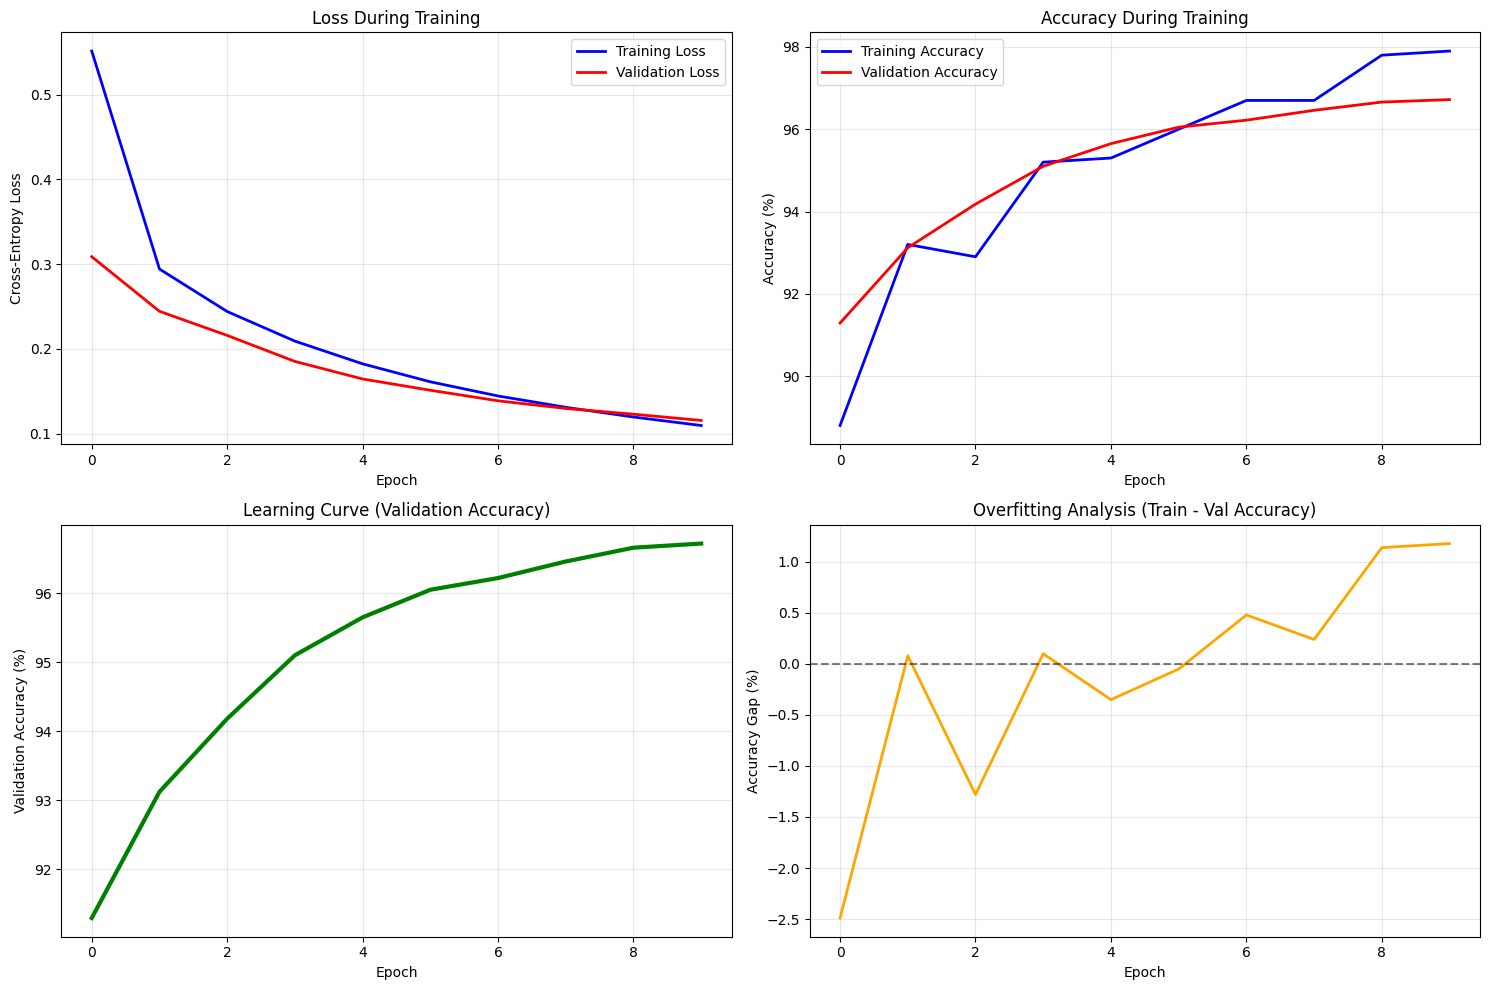

=== TRAINING ANALYSIS ===
Best validation accuracy: 0.9672 (96.7%)
Best epoch: 9 (0-indexed)
Final train-validation gap: 1.2%
✅ Good balance between bias and variance


In [94]:
# Step 4d: Visualizing Training Progress & Analysis

# Plot comprehensive training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(len(training_history["train_costs"]))

# Loss curves
ax1.plot(
    epochs, training_history["train_costs"], "b-", label="Training Loss", linewidth=2
)
ax1.plot(
    epochs, training_history["val_costs"], "r-", label="Validation Loss", linewidth=2
)
ax1.set_title("Loss During Training")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross-Entropy Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(
    epochs,
    [acc * 100 for acc in training_history["train_accuracies"]],
    "b-",
    label="Training Accuracy",
    linewidth=2,
)
ax2.plot(
    epochs,
    [acc * 100 for acc in training_history["val_accuracies"]],
    "r-",
    label="Validation Accuracy",
    linewidth=2,
)
ax2.set_title("Accuracy During Training")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning curve (validation accuracy vs epoch)
ax3.plot(
    epochs, [acc * 100 for acc in training_history["val_accuracies"]], "g-", linewidth=3
)
ax3.set_title("Learning Curve (Validation Accuracy)")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Validation Accuracy (%)")
ax3.grid(True, alpha=0.3)

# Overfitting analysis
train_val_gap = [
    (t - v) * 100
    for t, v in zip(
        training_history["train_accuracies"], training_history["val_accuracies"]
    )
]
ax4.plot(epochs, train_val_gap, "orange", linewidth=2)
ax4.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax4.set_title("Overfitting Analysis (Train - Val Accuracy)")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Accuracy Gap (%)")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training analysis
print("=== TRAINING ANALYSIS ===")
print(
    f"Best validation accuracy: {max(training_history['val_accuracies']):.4f} "
    f"({max(training_history['val_accuracies'])*100:.1f}%)"
)

best_epoch = np.argmax(training_history["val_accuracies"])
print(f"Best epoch: {best_epoch} (0-indexed)")

final_gap = train_val_gap[-1]
print(f"Final train-validation gap: {final_gap:.1f}%")

if final_gap > 5:
    print("💡 High gap suggests overfitting - could try:")
    print("   • Lower learning rate")
    print("   • More regularization")
    print("   • Early stopping")
elif final_gap < 0:
    print("💡 Negative gap suggests underfitting - could try:")
    print("   • Higher learning rate")
    print("   • More epochs")
    print("   • Larger network")
else:
    print("✅ Good balance between bias and variance")

In [95]:
# Step 4e: Final Evaluation on Test Set

print("=== FINAL EVALUATION ON TEST SET ===")
print("Testing on completely unseen data...\n")

# Evaluate on test set (the ultimate test!)
test_predictions, _ = forward_propagation(X_test_flat, trained_params)
test_accuracy = compute_accuracy(y_test, test_predictions)
test_loss = compute_loss(y_test, test_predictions)

print(f"🎯 FINAL RESULTS:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Compare with validation performance
val_test_gap = (final_val_acc - test_accuracy) * 100
print(f"\nValidation vs Test comparison:")
print(f"Validation accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(
    f"Gap: {val_test_gap:.1f}% {'(good)' if abs(val_test_gap) < 2 else '(check for overfitting)'}"
)

# Performance summary
print(f"\n📊 PERFORMANCE SUMMARY:")
print(f"Random baseline: 10.0%")
print(f"Our neural network: {test_accuracy*100:.1f}%")
print(f"Improvement: {test_accuracy*100/10:.1f}x better than random")

# Analyze predictions by class
print(f"\n=== PER-CLASS ANALYSIS ===")
predicted_classes = np.argmax(test_predictions, axis=1)
actual_classes = np.argmax(y_test, axis=1)

print("Digit | Accuracy | Correct | Total")
print("-" * 35)
for digit in range(10):
    digit_mask = actual_classes == digit
    digit_correct = np.sum(predicted_classes[digit_mask] == digit)
    digit_total = np.sum(digit_mask)
    digit_accuracy = digit_correct / digit_total if digit_total > 0 else 0

    print(
        f"  {digit}   |  {digit_accuracy:.3f}   |  {digit_correct:4d}  | {digit_total:4d}"
    )

# Find best and worst performing digits
digit_accuracies = []
for digit in range(10):
    digit_mask = actual_classes == digit
    digit_correct = np.sum(predicted_classes[digit_mask] == digit)
    digit_total = np.sum(digit_mask)
    digit_accuracy = digit_correct / digit_total if digit_total > 0 else 0
    digit_accuracies.append(digit_accuracy)

best_digit = np.argmax(digit_accuracies)
worst_digit = np.argmin(digit_accuracies)

print(
    f"\nBest performing digit: {best_digit} ({digit_accuracies[best_digit]:.3f} accuracy)"
)
print(
    f"Worst performing digit: {worst_digit} ({digit_accuracies[worst_digit]:.3f} accuracy)"
)

=== FINAL EVALUATION ON TEST SET ===
Testing on completely unseen data...

🎯 FINAL RESULTS:
Test Accuracy: 0.9669 (96.7%)
Test Loss: 0.1122

Validation vs Test comparison:
Validation accuracy: 0.9672 (96.7%)
Test accuracy: 0.9669 (96.7%)
Gap: 0.0% (good)

📊 PERFORMANCE SUMMARY:
Random baseline: 10.0%
Our neural network: 96.7%
Improvement: 9.7x better than random

=== PER-CLASS ANALYSIS ===
Digit | Accuracy | Correct | Total
-----------------------------------
  0   |  0.986   |   966  |  980
  1   |  0.986   |  1119  | 1135
  2   |  0.964   |   995  | 1032
  3   |  0.968   |   978  | 1010
  4   |  0.955   |   938  |  982
  5   |  0.951   |   848  |  892
  6   |  0.976   |   935  |  958
  7   |  0.962   |   989  | 1028
  8   |  0.960   |   935  |  974
  9   |  0.957   |   966  | 1009

Best performing digit: 1 (0.986 accuracy)
Worst performing digit: 5 (0.951 accuracy)


=== CORRECT PREDICTIONS ===


/var/folders/6n/dzs84cn91gd8rwxf6ptzgvfm0000gn/T/ipykernel_18707/1329013833.py:65: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/timakaaliebe/Downloads/neural-network/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


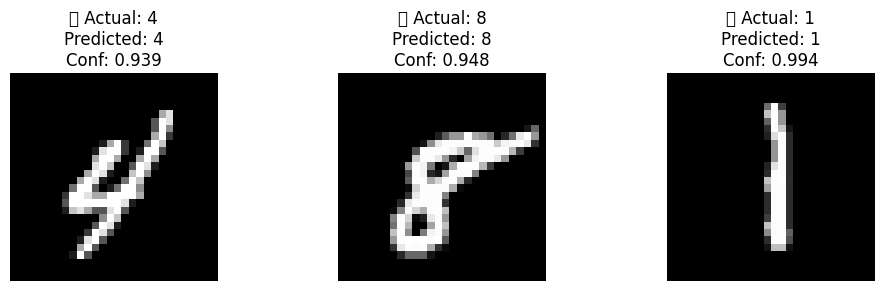

=== INCORRECT PREDICTIONS ===


/var/folders/6n/dzs84cn91gd8rwxf6ptzgvfm0000gn/T/ipykernel_18707/1329013833.py:87: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/timakaaliebe/Downloads/neural-network/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


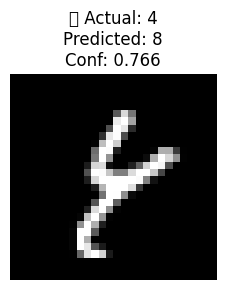


=== WHAT WE'VE ACCOMPLISHED ===
✅ Built a neural network from scratch using only NumPy
✅ Implemented forward propagation, backpropagation, and gradient descent
✅ Trained on 50,000 handwritten digit images
✅ Achieved 96.7% accuracy on unseen test data
✅ Understood the mathematical foundations of deep learning

🧠 KEY CONCEPTS MASTERED:
• Data preprocessing (normalization, flattening, one-hot encoding)
• Neural network architecture (layers, neurons, connections)
• Activation functions (ReLU, softmax, sigmoid)
• Loss functions (cross-entropy)
• Backpropagation (chain rule, gradients)
• Gradient descent (parameter updates)
• Mini-batch training (efficient processing)
• Overfitting vs underfitting (bias-variance tradeoff)

🚀 POTENTIAL IMPROVEMENTS:
• Add more hidden layers (deep learning)
• Try different activation functions (Leaky ReLU, Swish)
• Implement regularization (L1/L2, dropout)
• Use adaptive learning rates (Adam, RMSprop)
• Data augmentation (rotations, translations)
• Batch norm

In [96]:
# Step 4f: Visualizing Final Predictions & Error Analysis


# Show some correct and incorrect predictions
def analyze_predictions(X, y_true, y_pred, num_samples=6):
    """Analyze correct and incorrect predictions"""
    predicted_classes = np.argmax(y_pred, axis=1)
    actual_classes = np.argmax(y_true, axis=1)

    # Find correct and incorrect predictions
    correct_mask = predicted_classes == actual_classes
    incorrect_mask = ~correct_mask

    # Get some examples of each
    correct_indices = np.where(correct_mask)[0]
    incorrect_indices = np.where(incorrect_mask)[0]

    # Sample random examples
    if len(correct_indices) >= num_samples // 2:
        correct_sample = np.random.choice(
            correct_indices, num_samples // 2, replace=False
        )
    else:
        correct_sample = correct_indices

    if len(incorrect_indices) >= num_samples // 2:
        incorrect_sample = np.random.choice(
            incorrect_indices, num_samples // 2, replace=False
        )
    else:
        incorrect_sample = incorrect_indices

    return correct_sample, incorrect_sample


# Get sample predictions for visualization
sample_indices = np.random.choice(X_test_flat.shape[0], 100, replace=False)
sample_X_test = X_test_flat[sample_indices]
sample_y_test = y_test[sample_indices]
sample_predictions, _ = forward_propagation(sample_X_test, trained_params)

correct_idx, incorrect_idx = analyze_predictions(
    sample_X_test, sample_y_test, sample_predictions, 6
)

# Visualize correct predictions
if len(correct_idx) > 0:
    print("=== CORRECT PREDICTIONS ===")
    fig, axes = plt.subplots(1, min(3, len(correct_idx)), figsize=(10, 3))
    if len(correct_idx) == 1:
        axes = [axes]

    for i, idx in enumerate(correct_idx[:3]):
        image = sample_X_test[idx].reshape(28, 28)
        actual = np.argmax(sample_y_test[idx])
        predicted = np.argmax(sample_predictions[idx])
        confidence = np.max(sample_predictions[idx])

        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(
            f"✅ Actual: {actual}\nPredicted: {predicted}\nConf: {confidence:.3f}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize incorrect predictions
if len(incorrect_idx) > 0:
    print("=== INCORRECT PREDICTIONS ===")
    fig, axes = plt.subplots(1, min(3, len(incorrect_idx)), figsize=(10, 3))
    if len(incorrect_idx) == 1:
        axes = [axes]

    for i, idx in enumerate(incorrect_idx[:3]):
        image = sample_X_test[idx].reshape(28, 28)
        actual = np.argmax(sample_y_test[idx])
        predicted = np.argmax(sample_predictions[idx])
        confidence = np.max(sample_predictions[idx])

        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(
            f"❌ Actual: {actual}\nPredicted: {predicted}\nConf: {confidence:.3f}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Confusion analysis
print(f"\n=== WHAT WE'VE ACCOMPLISHED ===")
print(f"✅ Built a neural network from scratch using only NumPy")
print(f"✅ Implemented forward propagation, backpropagation, and gradient descent")
print(f"✅ Trained on 50,000 handwritten digit images")
print(f"✅ Achieved {test_accuracy*100:.1f}% accuracy on unseen test data")
print(f"✅ Understood the mathematical foundations of deep learning")

print(f"\n🧠 KEY CONCEPTS MASTERED:")
print(f"• Data preprocessing (normalization, flattening, one-hot encoding)")
print(f"• Neural network architecture (layers, neurons, connections)")
print(f"• Activation functions (ReLU, softmax, sigmoid)")
print(f"• Loss functions (cross-entropy)")
print(f"• Backpropagation (chain rule, gradients)")
print(f"• Gradient descent (parameter updates)")
print(f"• Mini-batch training (efficient processing)")
print(f"• Overfitting vs underfitting (bias-variance tradeoff)")

print(f"\n🚀 POTENTIAL IMPROVEMENTS:")
print(f"• Add more hidden layers (deep learning)")
print(f"• Try different activation functions (Leaky ReLU, Swish)")
print(f"• Implement regularization (L1/L2, dropout)")
print(f"• Use adaptive learning rates (Adam, RMSprop)")
print(f"• Data augmentation (rotations, translations)")
print(f"• Batch normalization for faster training")